In [1]:
import numpy as np 
import pandas as pd 
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [2]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

# EDA

In [3]:
train_df.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [4]:
print('Training Set Shape = {}'.format(train_df.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(train_df.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(test_df.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(test_df.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [5]:
train_df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

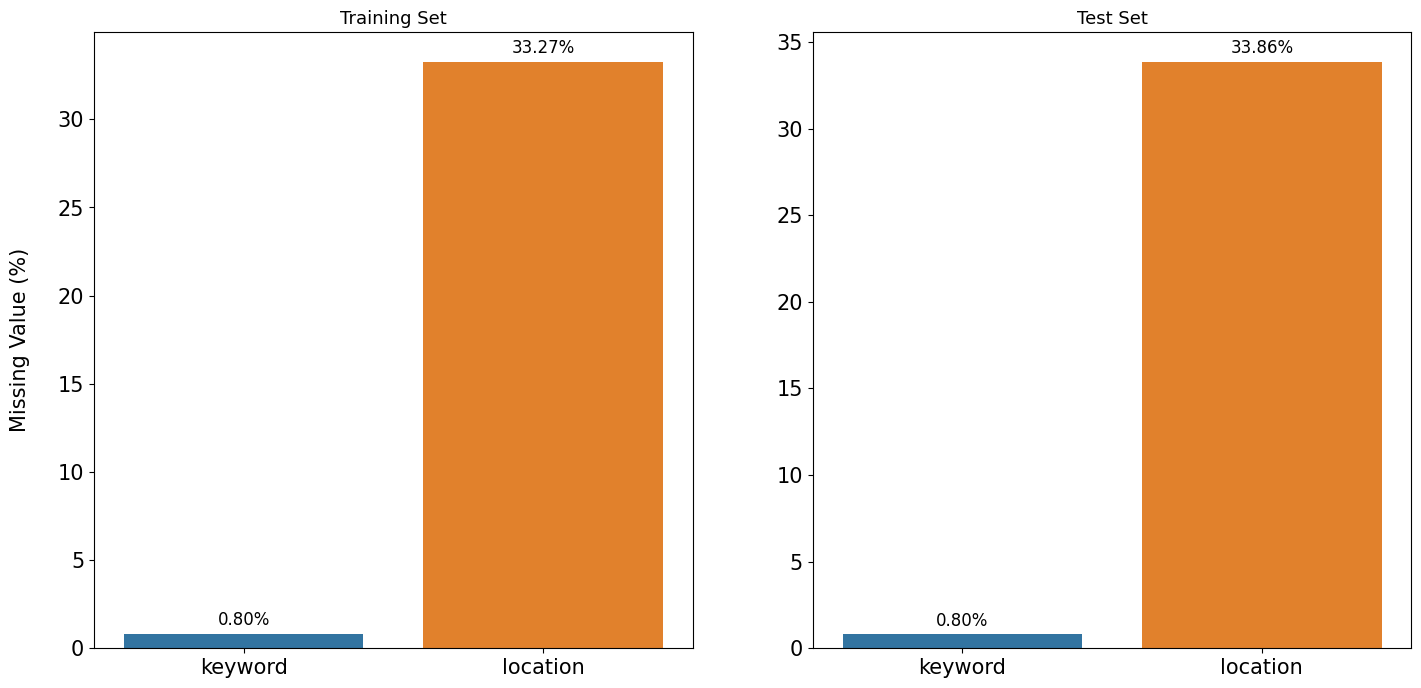

In [6]:
missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(17, 8), dpi=100)

train_missing_percent = train_df[missing_cols].isnull().sum() / len(train_df) * 100
sns.barplot(x=train_missing_percent.index, y=train_missing_percent.values, ax=axes[0])


test_missing_percent = test_df[missing_cols].isnull().sum() / len(test_df) * 100
sns.barplot(x=test_missing_percent.index, y=test_missing_percent.values, ax=axes[1])

for i, value in enumerate(train_missing_percent.values):
    axes[0].text(i, value + 0.5, f"{value:.2f}%", ha="center", fontsize=12)

for i, value in enumerate(test_missing_percent.values):
    axes[1].text(i, value + 0.5, f"{value:.2f}%", ha="center", fontsize=12)

axes[0].set_ylabel('Missing Value (%)', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)

plt.show()

In [7]:
print(f'# unique values in keyword column = {train_df["keyword"].nunique()} (Training set) -- {test_df["keyword"].nunique()} (Test set)')
print(f'# unique values in location column = {train_df["location"].nunique()} (Training set) -- {test_df["location"].nunique()} (Test set)')

# unique values in keyword column = 221 (Training set) -- 221 (Test set)
# unique values in location column = 3341 (Training set) -- 1602 (Test set)


In [8]:
train_keywords_set = set(train_df['keyword'].dropna())
test_keywords_set = set(test_df['keyword'].dropna())

In [9]:
common_keywords = train_keywords_set.intersection(test_keywords_set)
print(f"Number of keywords in the intersection: {len(common_keywords)}")

Number of keywords in the intersection: 221


In [10]:
train_unique = train_keywords_set - test_keywords_set 
test_unique = test_keywords_set - train_keywords_set  

print("Keywords in training set but not in test set:")
print(train_unique)

print("\nKeywords in test set but not in training set:")
print(test_unique)

Keywords in training set but not in test set:
set()

Keywords in test set but not in training set:
set()


In [11]:
for df in [train_df, test_df]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


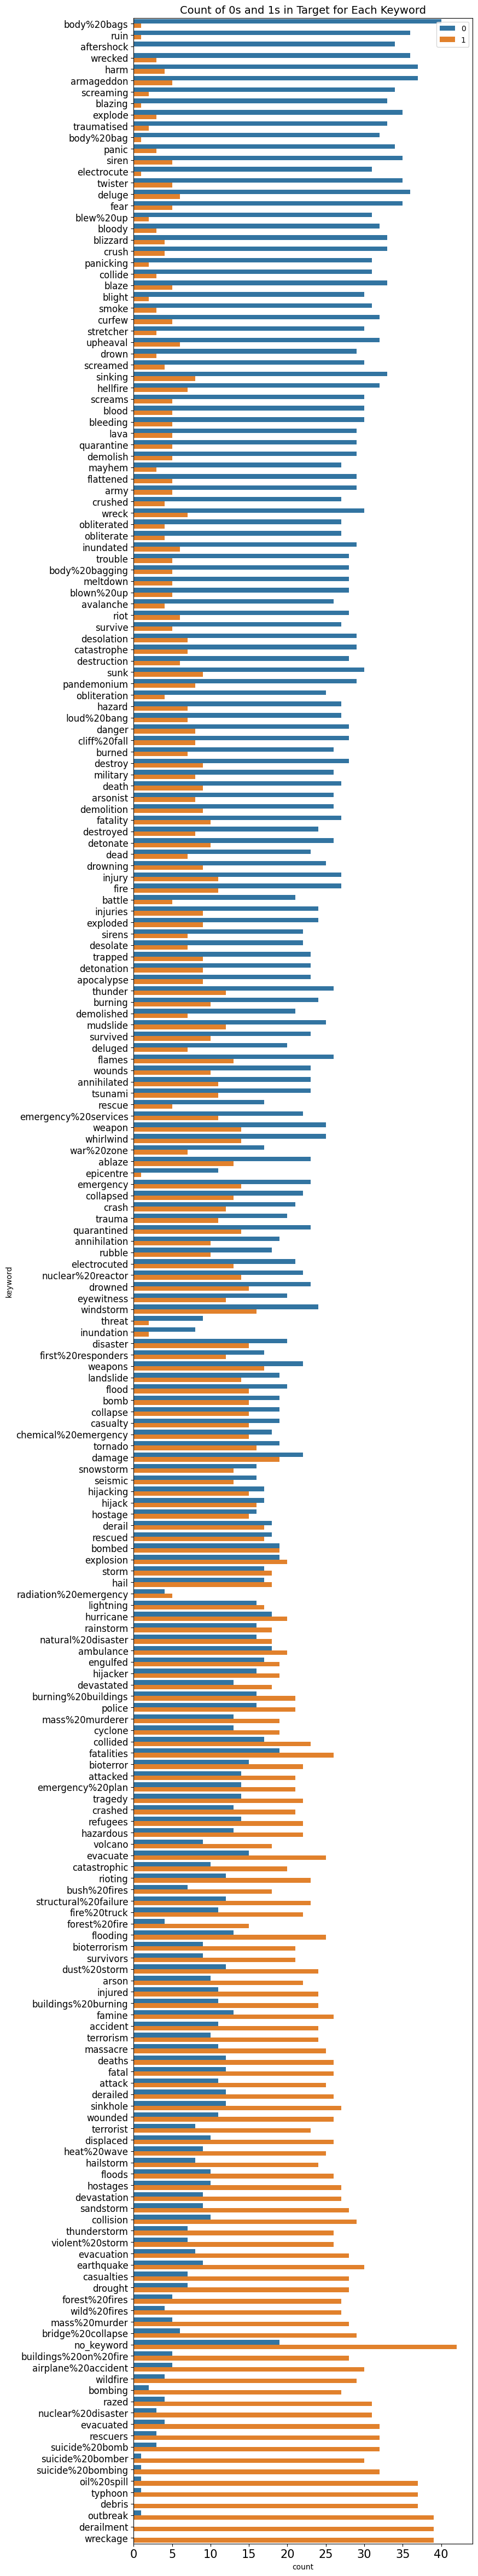

In [12]:
# Count the number of 0's and 1's in 'target' for each 'keyword'
keyword_target_counts = train_df.groupby(['keyword', 'target']).size().reset_index(name='count')
total_counts = keyword_target_counts.pivot(index='keyword', columns='target', values='count').fillna(0)
total_counts.columns = ['count_target_0', 'count_target_1']
total_counts['sort_order'] = total_counts['count_target_0'] - total_counts['count_target_1']

sorted_keywords = total_counts.sort_values(by='sort_order', ascending=False).index
keyword_target_counts['keyword'] = pd.Categorical(
    keyword_target_counts['keyword'], categories=sorted_keywords, ordered=True
)

fig = plt.figure(figsize=(8,60), dpi=100)
sns.barplot(data=keyword_target_counts, x='count', y='keyword', hue='target')

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.title("Count of 0s and 1s in Target for Each Keyword", fontsize=14)
plt.legend(loc=1)
# plt.legend(title="Target", fontsize=10)

plt.show()



In [13]:
train_df["length"] = train_df["text"].apply(lambda x : len(x))
test_df["length"] = test_df["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(train_df["length"].describe())
print()

print("Test Length Stat")
print(test_df["length"].describe())

train_df.drop('length', axis=1, inplace=True)
test_df.drop('length', axis=1, inplace=True)

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


In [14]:
from wordcloud import STOPWORDS
import string

In [15]:
train_df['stop_word_count'] = train_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

train_df['url_count'] = train_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

train_df['tweet_length'] = train_df['text'].apply(lambda x: len(str(x)))

train_df['punctuation_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

train_df['hashtag_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c=='#']))

train_df['mention_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))


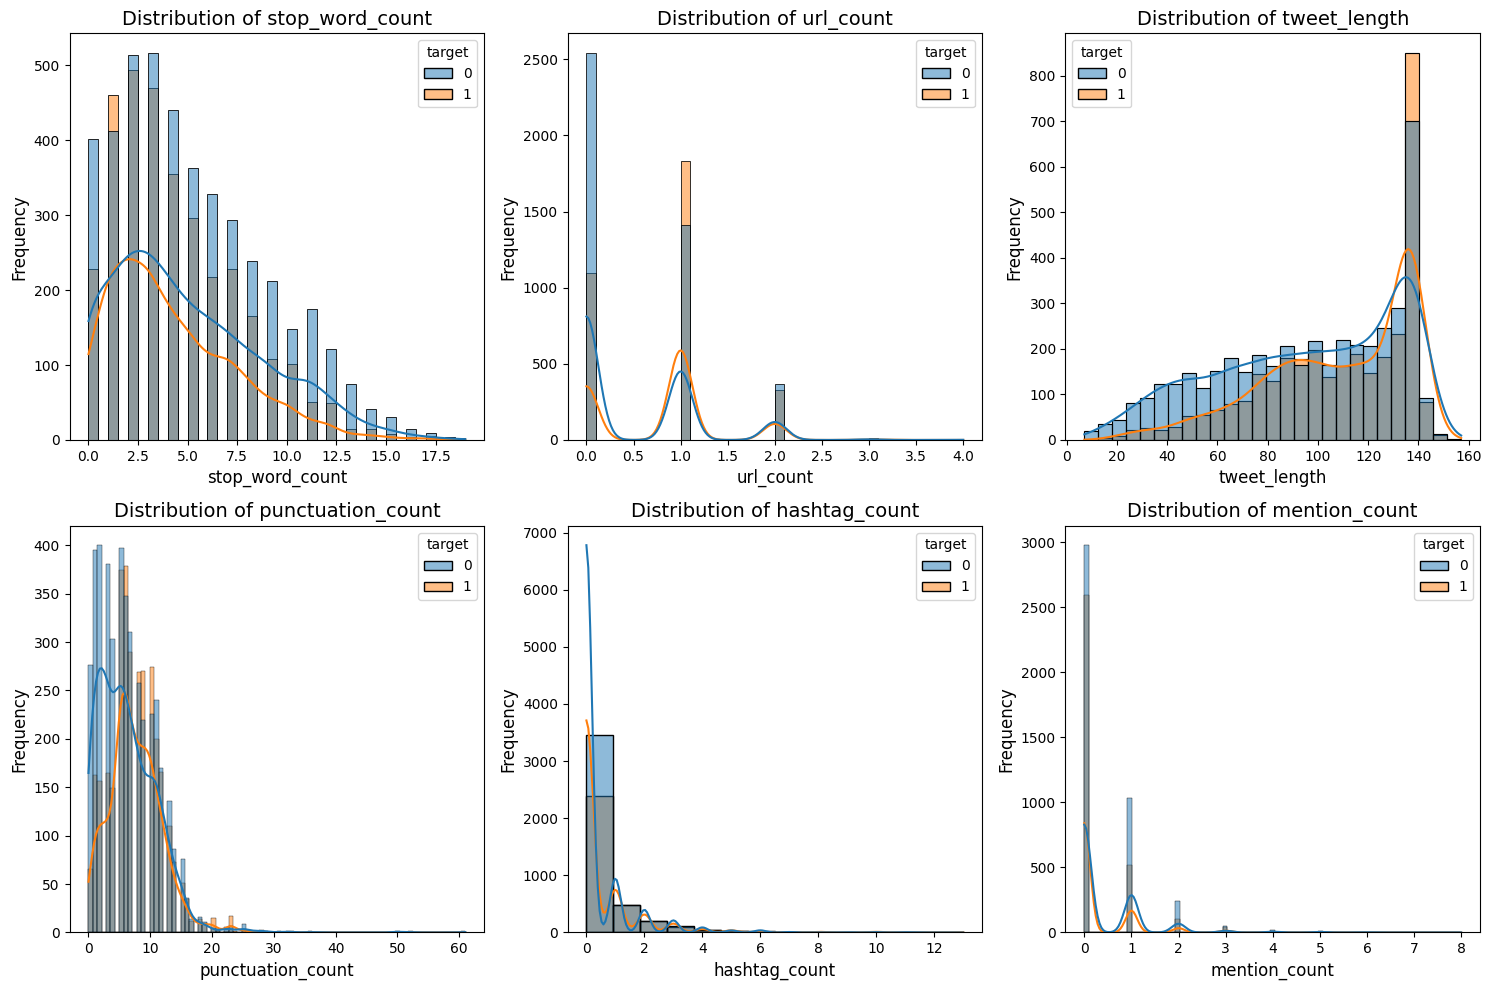

In [16]:
import warnings
warnings.filterwarnings("ignore")

tweets_properties = ['stop_word_count', 'url_count', 'tweet_length', 'punctuation_count', 'hashtag_count', 'mention_count']
disaster_tweets = train_df['target'] == 1

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easy iteration

for i, property in enumerate(tweets_properties):
    sns.histplot(data=train_df, x=property, kde=True, hue='target', ax=axes[i])
    axes[i].set_title(f'Distribution of {property}', fontsize=14)
    axes[i].set_xlabel(property, fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [17]:
mislabelled_df  = train_df.groupby(['text']).nunique().sort_values(by='target', ascending=False)
mislabelled_df = mislabelled_df[mislabelled_df['target'] > 1]['target']
mislabelled_df.index.tolist()

['like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit',
 'Hellfire! We don\x89Ûªt even want to think about it or mention it so let\x89Ûªs not do anything that leads to it #islam!',
 "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'",
 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!',
 'To fight bioterrorism sir.',
 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE',
 '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption',
 '#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect',
 'He came to a land which was engulfed in tribal war and turned it into a land 

In [18]:
len(mislabelled_df)

18

In [19]:
train_df['target_relabeled'] = train_df['target'].copy() 
train_df.head(2)

,id,keyword,location,text,target,stop_word_count,url_count,tweet_length,punctuation_count,hashtag_count,mention_count,target_relabeled
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,6,0,69,1,1,0,1
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,0,0,38,1,0,0,1


In [20]:
train_df.loc[train_df['text'] == 'like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == 'Hellfire! We don\x89Ûªt even want to think about it or mention it so let\x89Ûªs not do anything that leads to it #islam!', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'", 'target_relabeled'] = 0
train_df.loc[train_df['text'] == 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == 'To fight bioterrorism sir.', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE' , 'target_relabeled'] = 0
train_df.loc[train_df['text'] == '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == '#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == 'He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == 'RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == 'Hellfire is surrounded by desires so be careful and don\x89Ûªt let your desires control you! #Afterlife', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == "Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...", 'target_relabeled'] = 0
train_df.loc[train_df['text'] == 'wowo--=== 12000 Nigerian refugees repatriated from Cameroon', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == 'I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == 'that horrible sinking feeling when you\x89Ûªve been at home on your phone for a while and you realise its been on 3G this whole time', 'target_relabeled'] = 0

train_df.loc[train_df['text'] == 'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring', 'target_relabeled'] = 1
train_df.loc[train_df['text'] == '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4', 'target_relabeled'] = 1
train_df.loc[train_df['text'] == 'Caution: breathing may be hazardous to your health.', 'target_relabeled'] = 1


In [21]:
train_df.loc[train_df['target'] != train_df['target_relabeled']]

,id,keyword,location,text,target,stop_word_count,url_count,tweet_length,punctuation_count,hashtag_count,mention_count,target_relabeled
610,881,bioterrorism,no_location,To fight bioterrorism sir.,1,1,0,26,1,0,0,0
630,907,bioterrorism,no_location,To fight bioterrorism sir.,1,1,0,26,1,0,0,0
1197,1723,buildings%20burning,"Mackay, QLD, Australia",Mmmmmm I'm burning.... I'm burning buildings I...,1,3,0,84,14,0,0,0
1221,1760,buildings%20burning,dallas,like for the music video I want some real acti...,1,9,0,125,0,0,0,0
1365,1968,burning%20buildings,"Epic City, BB.",I Pledge Allegiance To The P.O.P.E. And The Bu...,1,6,0,82,11,0,0,0
2832,4076,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #G...,0,3,1,134,13,2,0,1
3243,4659,engulfed,Kuwait,He came to a land which was engulfed in tribal...,1,11,0,123,5,2,0,0
3248,4669,engulfed,Bahrain,He came to a land which was engulfed in tribal...,1,11,0,123,5,2,0,0
3985,5662,floods,no_location,Who is bringing the tornadoes and floods. Who ...,1,12,0,137,4,2,0,0
4221,5996,hazardous,no_location,#foodscare #offers2go #NestleIndia slips into ...,1,4,0,117,6,6,0,0


# preprocess data

In [22]:
# !pip install keras-core --upgrade
# !pip install -q keras-nlp --upgrade

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [23]:
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

Using TensorFlow backend
TensorFlow version: 2.16.1
KerasNLP version: 0.15.1


In [24]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = train_df.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

In [25]:
from sklearn.model_selection import train_test_split

train_df["combined_text"] = train_df['keyword'] + " | " + train_df['text']
test_df["combined_text"] = test_df['keyword'] + " | " + test_df['text']
X = train_df["combined_text"]
y = train_df["target_relabeled"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = test_df["combined_text"]

# Load DistilBERT model from Keras NLP

> DistilBERT is a small, fast, cheap and light Transformer model trained by distilling BERT base. It has 40% less parameters than google-bert/bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances as measured on the GLUE language understanding benchmark.

In [26]:
preset = "distil_bert_base_en_uncased"

preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
    preset,
    sequence_length=160,
    name="preprocessor_4_tweets"
)

classifier = keras_nlp.models.DistilBertClassifier.from_preset(
    preset,
    preprocessor=preprocessor,
    num_classes=2
)

classifier.summary()

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)                   │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "distil_bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

# Fine-tune BERT

In [27]:
from keras.optimizers import Adam
# from tensorflow.keras.optimizers import Adam
# Compile -  Configure the Classifier task for training.
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #'binary_crossentropy',
    optimizer=Adam(1e-5),
    metrics= ["accuracy"]  
)


# Fine-tune
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS, 
                         validation_data=(X_val, y_val)
                        )

Epoch 1/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 3562s 19s/step - accuracy: 0.7205 - loss: 0.5660 - val_accuracy: 0.8372 - val_loss: 0.3941
Epoch 2/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 3555s 19s/step - accuracy: 0.8430 - loss: 0.3808 - val_accuracy: 0.8470 - val_loss: 0.3764


In [28]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset --- F1 Score: " + str(f1_score.round(2)))

48/48 ━━━━━━━━━━━━━━━━━━━━ 223s 5s/step


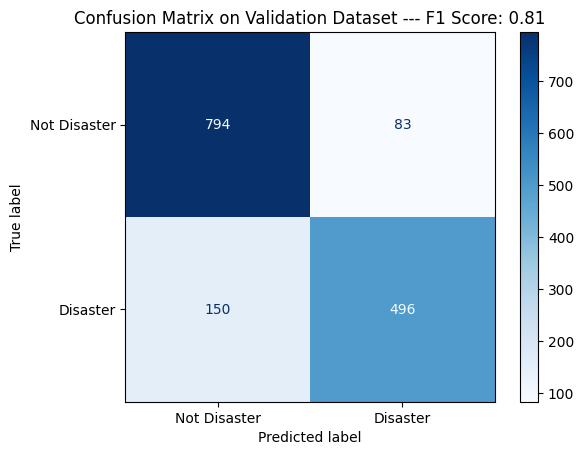

In [29]:
y_pred_val = classifier.predict(X_val)

displayConfusionMatrix(y_val, y_pred_val, "Validation")

# Predict Test

In [30]:
y_test = classifier.predict(X_test)
y_test

102/102 ━━━━━━━━━━━━━━━━━━━━ 477s 5s/step


array([[-1.1948661 ,  1.0705551 ],
       [-1.2637528 ,  1.2244588 ],
       [-1.3573074 ,  1.2734873 ],
       ...,
       [-1.882136  ,  1.7255695 ],
       [-0.8368601 ,  0.71160156],
       [-0.562593  ,  0.54094964]], dtype=float32)

In [31]:
y_test_class = np.argmax(y_test, axis=1)
y_test_class

array([1, 1, 1, ..., 1, 1, 1])

In [32]:
y_test_class[y_test_class == 0].size
# y_test_class.size

2077

In [33]:
output_df = pd.DataFrame({
    'id': test_df['id'],       
    'target': y_test_class           
})

In [34]:
output_df.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [35]:
output_csv_path = '/kaggle/working/submission.csv' 
output_df.to_csv(output_csv_path, index=False)